<a href="https://colab.research.google.com/github/RashmiChrystal/FYP/blob/main/FYP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Anomaly Detection in Image Streams with Machine Learning**

The code has been changed to process the new dataset (big one) and the previous lines have been commented so pay attention to it.

# **Progress**

## Import Required Libraries

In [ ]:
pip install pmdarima

     |████████████████████████████████| 1.4 MB 4.2 MB/s 
     |████████████████████████████████| 9.8 MB 37.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import cv2
import numpy as np
import pandas as pd
import os
import glob
import math
from skimage.filters import roberts, sobel, scharr, prewitt
from scipy import ndimage as nd
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage import io
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as sklearnPCA
from matplotlib import pyplot as plt
from skimage.feature import greycomatrix, greycoprops
import io
from math import sqrt

## Upload the Dataset from a local directory.

The dataset contains a series of images and a zipped folder is uploaded here.

In [ ]:
from google.colab import files
uploadedData = files.upload()

Saving smallDataset.zip to smallDataset.zip


The zipped dataset folder is unfolded and extracted using the following code.

In [ ]:
import zipfile
#data = zipfile.ZipFile(io.BytesIO(uploadedData['converted images.zip']), 'r')
#data = zipfile.ZipFile(io.BytesIO(uploadedData['Normal.zip']), 'r')
data = zipfile.ZipFile(io.BytesIO(uploadedData['smallDataset.zip']), 'r')
data.extractall()
#data.printdir()

The image data is read and stored in a list named list_3.

In [ ]:
list_3 = []
list_4 = []

filenames = glob.glob("smallDataset/"+"*.jpg")
#filenames = glob.glob("Normal/"+"*.jpg")
filenames.sort()
for img in filenames:
  n = cv2.imread(img, 0)
  if n is not None:
    list_3.append(n)
    list_4.append(img)
print("The length of the image dataset: ", len(list_3))

The length of the image dataset:  100


In [ ]:
anomaly_image = int(input("Input the number of the image in which the anomaly begins: "))
dataset_length = len(list_3)

## Preprocessing of the data

In [ ]:
crop_y = list_3[0].shape[0] - 40
crop_x = list_3[0].shape[1]

In [ ]:
def crop_image(img):  #crop_x, crop_y
  cropped_image = img[0:crop_y, 0:crop_x]
  return cropped_image

In [ ]:
from google.colab.patches import cv2_imshow

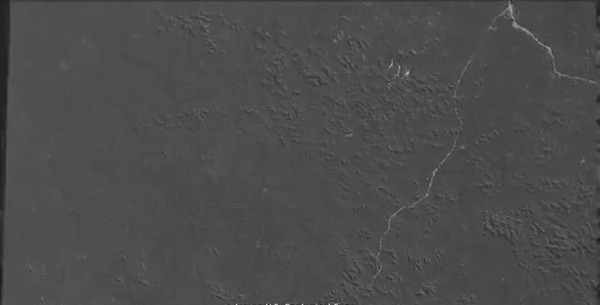

-1

In [ ]:
cropped_img = crop_image(list_3[0])
cv2_imshow(cropped_img)
cv2.waitKey(0)

Contrast Stretching is done on the images.

The equation of the contrast stretching function is as follows,


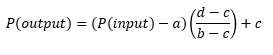

      where, P(output) = the value of the output pixel
      P(input) = the value of the input pixel
      a = lowest gray level value of the original image
    	b = highest gray level value of the original image
      c = lowest gray level value needed in the output image
      d = highest gray level value needed in the output image


In [ ]:
def contrastStretching(image):
    plt.hist(image.ravel(), 256, [0, 256])
    frame1 = image.copy()
    
    xp1 = [5, 50, 145, 250]
    fp1 = [5, 10, 245, 250]
    y = np.arange(256)
    table1 = np.interp(y, xp1, fp1).astype('uint8')
    frame1 = cv2.LUT(frame1, table1)
    plt.hist(frame1.ravel(), 256, [0, 256])
    #plt.show()
    return frame1

Noise removal is done by using the Gaussian Filter

The 2D isotropic Gaussian kernel,

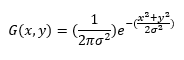

    where, G(x,y) = Gaussian distribution
	  σ = standard deviation


In [ ]:
def gaussianBlur(image):
    gaussian = cv2.GaussianBlur(image,(5,5),0)
    return gaussian

## Feature Extraction

Function to calculate the histogram of a given image. 

This will be needed for the calculation of the first-order statistical features.

In [ ]:
def calcHistogram(image):
    hist, edges, patches = plt.hist(image.ravel(), 256, [0, 256])
    return hist

Function to find the average of the calculated values for each pixel/pixel neighbourhoods of an image.

In [ ]:
def findAverage(list):
    avg = sum(list)/len(list)
    return avg

In [ ]:
#Extracting features
G = 256 #NUmber of gray levels in an image

### First-Order Statistical Features

Function to calculate the probability density value that will be needed for the first-order feature calculation.

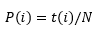

    where, P(i) = probability density of the intensity level, i
	  t(i) = the total number of pixels that has the intensity level, i
	  N = the total number of pixels in the image


In [ ]:
def calc_Probability_Density(hist_i_value, size):
    return (hist_i_value/size)

Statistical Mean calculation

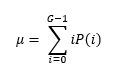

In [ ]:
def Stat_Mean(i, prob_density):
    mean = (i * (prob_density))
    return mean

Average COntrast calculation

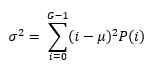

In [ ]:
def Stat_Avg_Contrast(i, prob_density, mean):
    avg_contrast = pow((i-mean),2) * prob_density
    return avg_contrast

Skewness of a pixel calculation

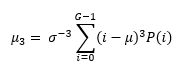

In [ ]:
def Stat_Skewness(i, mean, prob_density):
    skewness_component = pow((i-mean),3) * prob_density
    return skewness_component

Kurtosis of a pixel calculation

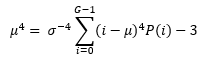

In [ ]:
def Stat_Kurtosis(i, mean, prob_density):
    kurtosis_component = (pow((i-mean),4) * prob_density) - 3
    return kurtosis_component

Energy of a pixel calculation

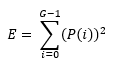

In [ ]:
def Stat_Energy(prob_density):
    energy = pow(prob_density,2)
    return energy

In [ ]:
#function for 4: contrast, skewness, kurtosis, energy
def Stat_Features_Set1(i, mean, prob_density):
    avg_contrast = pow((i - mean), 2) * prob_density
    skewness_component = pow((i - mean), 3) * prob_density
    kurtosis_component = (pow((i - mean), 4) * prob_density) - 3
    energy = pow(prob_density, 2)
    return avg_contrast, skewness_component, kurtosis_component, energy

In [ ]:
def calc_Stat_Features(img):
    Return_Set = []
    stat_mean=0
    stat_avg_contrast=0
    skewness_component=0
    kurtosis_component=0
    stat_energy=0
    hist = calcHistogram(img)
    size = img.size

    for i in range(G):
        p_d = calc_Probability_Density(hist[i], size)
        stat_mean += Stat_Mean(i, p_d)
        
    for i in range(G):
        p_d = calc_Probability_Density(hist[i], size)
        p1, p2, p3, p4 = Stat_Features_Set1(i, stat_mean, p_d)
        stat_avg_contrast += p1  # variance^2 (avg_contrast)
        skewness_component += p2 #skewness_component
        kurtosis_component += p3 #kurtosis_component
        stat_energy += p4 #energy

    skewness = pow(stat_avg_contrast,(-3/2)) * skewness_component
    kurtosis = pow(stat_avg_contrast,(-4/2)) * kurtosis_component
    return stat_mean, stat_avg_contrast, skewness, kurtosis, stat_energy

### Gabor Wavelet Feature Extraction

The Gabor function used,

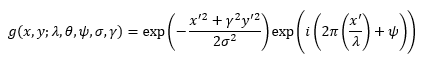

    where, x^'=xcos⁡θ + ysin⁡θ
	  y^'=-xsin⁡θ + ycos⁡θ
	  λ=wavelength of the sine component
	  θ=orientation of the parallel lines formed by the kernel
	  ψ=phase offset
	  σ=standard deviation of the gaussian envelope
	  ϒ=aspect ratio


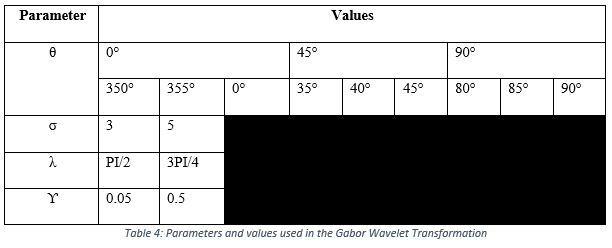

In [ ]:
def gaborFilter(img):
    num = 1
    fimg_list = []
    for theta in range(3):  # 0, 45, 90
        theta = theta / 4 * np.pi  # theta 0, 1/4, 1/2 => 0, 45, 90
        for theta_i in (theta - 10, theta - 5, theta):
            for sigma in (3, 5):
                for lamda in np.arange(np.pi / 2, np.pi, np.pi / 4):
                    for gamma in (0.05, 0.5):
                        gabor_label = 'Gabor' + str(num)
                        kernel = cv2.getGaborKernel((5, 5), sigma, theta_i, lamda, gamma, 0,
                                                    ktype=cv2.CV_32F)  # ktype is the data type. so it's saying that after the kernel is generated, store it as 32 float
                       
                        fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
                        filtered_img = fimg.reshape(-1)
                  
                        fimg_list.append(fimg)
                        
                        num += 1
    return fimg_list

### Edge Detected Features

In [ ]:
def cannyEdge(img):
    edges = cv2.Canny(img, 100, 200)
    edges2 = edges.reshape(-1)
    return edges2

In [ ]:
def edge_roberts(img):
    edge_robert = roberts(img)
    edge_robert2 = edge_robert.reshape(-1)
    return edge_robert2

In [ ]:
def edge_sobel(img):
    edge_sobel1 = sobel(img)
    edge_sobel2 = edge_sobel1.reshape(-1)
    return edge_sobel2

In [ ]:
def edge_scharr(img):
    edge_scharr1 = scharr(img)
    edge_scharr2 = edge_scharr1.reshape(-1)
    return edge_scharr2

In [ ]:
def edge_prewitt(img):
    edge_prewitt1 = prewitt(img)
    edge_prewitt2 = edge_prewitt1.reshape(-1)
    return edge_prewitt2

### Other extracted features: Gaussian S3 and S7, Entropy features

In [ ]:
def gaussianFeature(img):
    gaussian_img = nd.gaussian_filter(img, sigma = 3) #Gaussian S3
    gaussian_img1 = gaussian_img.reshape(-1)
    gaussian_img2 = nd.gaussian_filter(img, sigma=7) #Gaussian S7
    gaussian_img3 = gaussian_img2.reshape(-1)
    return gaussian_img1, gaussian_img3

In [ ]:
def entropyFeature(img):
    entropy_img = entropy(img, disk(1))
    entropy_img1 = entropy_img.reshape(-1)
    return entropy_img1

### GLCM Feature Extraction

In [ ]:
def glcmFeatures(img):
    glcm = greycomatrix(img, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    diss_sim = greycoprops(glcm, 'dissimilarity')[0, 0] # [0,0] to convert array to value
    corr = greycoprops(glcm, 'correlation')[0, 0]
    homogen = greycoprops(glcm, 'homogeneity')[0, 0]
    energy = greycoprops(glcm, 'energy')[0, 0]
    contrast = greycoprops(glcm, 'contrast')[0, 0]
    return diss_sim, corr, homogen, energy, contrast

### Preparing for Feature extraction

Defining the lists needed to store the calculated features for each image.

In [ ]:
contrast_stretched_image_list = []
num_CS = 0
Canny_Edges_list = []
Edge_Roberts_List = []
Edge_Sobel_List = []
Edge_Scharr_List = []
Edge_Prewitt_List = []
Gaussian_img1_List = []
Gaussian_img3_List = []
Variance_list = []
Stat_Mean_List = []
Stat_Avg_Contrast_List = []
Stat_Skewness_List = []
Stat_Kurtosis_List = []
Stat_Energy_List = []
Stat_Entropy_List = []
Gabor_Individual_List = []
GLCM_diss_sim_List = []
GLCM_corr_List = []
GLCM_homogen_List = []
GLCM_energy_List = []
GLCM_contrast_List = []

In [ ]:
df = pd.DataFrame()
#df_sift = pd.DataFrame()
df_newFeatures1 = pd.DataFrame()

### Feature Extraction

Extracting features for each image from the dataset.

length of images list,  100
0
length of images list,  100
1
length of images list,  100
2
length of images list,  100
3
length of images list,  100
4
length of images list,  100
5
length of images list,  100
6
length of images list,  100
7
length of images list,  100
8
length of images list,  100
9
length of images list,  100
10
length of images list,  100
11
length of images list,  100
12
length of images list,  100
13
length of images list,  100
14
length of images list,  100
15
length of images list,  100
16
length of images list,  100
17
length of images list,  100
18
length of images list,  100
19
length of images list,  100
20
length of images list,  100
21
length of images list,  100
22
length of images list,  100
23
length of images list,  100
24
length of images list,  100
25
length of images list,  100
26
length of images list,  100
27
length of images list,  100
28
length of images list,  100
29
length of images list,  100
30
length of images list,  100
31
length of images l

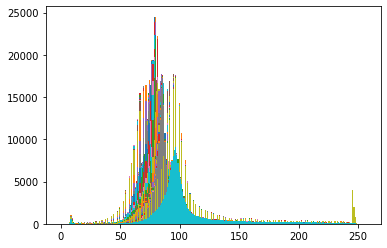

In [ ]:
for img in list_3:
  print("length of images list, ", len(list_3))
  cropped_img = crop_image(img)
  CS_img = contrastStretching(cropped_img)
  contrast_stretched_image_list.append(CS_img)
  gaussian_img = gaussianBlur(CS_img)

  canny_edges2 = cannyEdge(gaussian_img)
  avg_canny_edges2 = findAverage(canny_edges2)
  Canny_Edges_list.append(avg_canny_edges2)

  edge_robert2 = edge_roberts(gaussian_img)
  avg_edge_roberts2 = findAverage(edge_robert2)
  Edge_Roberts_List.append(avg_edge_roberts2)

  edge_sobel2 = edge_sobel(gaussian_img)
  avg_edge_sobel2 = findAverage(edge_sobel2)
  Edge_Sobel_List.append(avg_edge_sobel2)

  edge_scharr2 = edge_scharr(gaussian_img)
  avg_edge_scharr2 = findAverage(edge_scharr2)
  Edge_Scharr_List.append(avg_edge_scharr2)

  edge_prewitt2 = edge_prewitt(gaussian_img)
  avg_edge_prewitt2 = findAverage(edge_prewitt2)
  Edge_Prewitt_List.append(avg_edge_prewitt2)

  gaussian_img1, gaussian_img3 = gaussianFeature(gaussian_img)
  avg_gaussian_img1 = findAverage(gaussian_img1)
  avg_gaussian_img3 = findAverage(gaussian_img3)
  Gaussian_img1_List.append(avg_gaussian_img1)
  Gaussian_img3_List.append(avg_gaussian_img3)

  entropy_img1 = entropyFeature(gaussian_img)
  avg_entropy_img1 = findAverage(entropy_img1)
  Variance_list.append(avg_entropy_img1)

  gabor_images = gaborFilter(gaussian_img)
  total_gabor_image_values = [] #42 elements
  for img in gabor_images:
    g = img.reshape(-1)
    avg_g = findAverage(g)
    total_gabor_image_values.append(avg_g)
  
  Gabor_Individual_List.append(total_gabor_image_values)

  stat_mean, stat_avg_contrast, skewness, kurtosis, stat_energy = calc_Stat_Features(gaussian_img)
  Stat_Mean_List.append(stat_mean)
  Stat_Avg_Contrast_List .append(stat_avg_contrast)
  Stat_Skewness_List.append(skewness)
  Stat_Kurtosis_List.append(kurtosis)
  Stat_Energy_List.append(stat_energy)

  diss_sim, corr, homogen, energy, contrast = glcmFeatures(gaussian_img)
  GLCM_diss_sim_List.append(diss_sim)
  GLCM_corr_List.append(corr)
  GLCM_homogen_List.append(homogen)
  GLCM_energy_List.append(energy)
  GLCM_contrast_List.append(contrast)

  print(num_CS)
  num_CS = num_CS + 1
  

In [ ]:
Gabor_Total_Dict = {}
for i in range(len(Gabor_Individual_List[0])):
  Gabor_Total_Dict['GB'+str(i)]=[]

for i in Gabor_Individual_List:
  image_values = i
  num = 0
  for j in image_values:
    label = 'GB'+str(num)
    val = Gabor_Total_Dict[label]
    val.append(j)
    Gabor_Total_Dict[label] = val
    num += 1

print("Length of the Gabor dictionary", len(Gabor_Total_Dict))
Gray_Images_List = []
for i in range(len(list_3)):
  Gray_Images_List.append(i+1)

Length of the Gabor dictionary 72


In [ ]:
from google.colab import drive
drive.mount('drive')

### Putting the extracted feature data into a Pandas Dataframe.

In [ ]:
df_newFeatures1['Gray Level Images'] = Gray_Images_List
df_newFeatures1['CannyEdge'] = Canny_Edges_list
df_newFeatures1['EdgeRoberts'] = Edge_Roberts_List
df_newFeatures1['EdgeSobel'] = Edge_Sobel_List
df_newFeatures1['EdgeScharr'] = Edge_Scharr_List
df_newFeatures1['EdgePrewitt'] = Edge_Prewitt_List
df_newFeatures1['StatMean'] = Stat_Mean_List
df_newFeatures1['StatAvgContrast'] = Stat_Avg_Contrast_List
df_newFeatures1['StatSkewness'] = Stat_Skewness_List
df_newFeatures1['StatKurtosis'] = Stat_Kurtosis_List
df_newFeatures1['StatEnergy'] = Stat_Energy_List
# df_newFeatures1['StatEntropy'] = Stat_Entropy_List
df_newFeatures1['Gaussian1'] = Gaussian_img1_List
df_newFeatures1['Gaussian3'] = Gaussian_img3_List
df_newFeatures1['Entropy'] = Variance_list

Gabor_num = 0
for i in range(len(Gabor_Total_Dict)):
  label = 'GB' + str(Gabor_num)
  val = Gabor_Total_Dict[label]
  df_newFeatures1[label] = val
  Gabor_num += 1

df_newFeatures1['GLCM_Diss_similarity'] = GLCM_diss_sim_List
df_newFeatures1['GLCM_Correlation'] = GLCM_corr_List
df_newFeatures1['GLCM_Homogeneity'] = GLCM_homogen_List
df_newFeatures1['GLCM_Energy'] = GLCM_energy_List
df_newFeatures1['GLCM_Contrast'] = GLCM_contrast_List

print(df_newFeatures1.head())

df_newFeatures1.to_csv('drive/MyDrive/UOM/FYP/Features.csv')
print("end")

### Plotting the Feature data

In [ ]:
plt.plot(df_newFeatures1['Gray Level Images'], df_newFeatures1['StatAvgContrast'], label="StatAvgContrast")
plt.xlabel('Gray Images in the dataset')
plt.title('Distribution of features of Gray Level images - Set 1')
plt.legend()
plt.show()

In [ ]:
plt.plot(df_newFeatures1['Gray Level Images'], df_newFeatures1['CannyEdge'], label="CannyEdge")
plt.plot(df_newFeatures1['Gray Level Images'], df_newFeatures1['EdgeRoberts'], label="EdgeRoberts")
plt.plot(df_newFeatures1['Gray Level Images'], df_newFeatures1['EdgeSobel'], label="EdgeSobel")
plt.plot(df_newFeatures1['Gray Level Images'], df_newFeatures1['EdgeScharr'], label="EdgeScharr")
plt.plot(df_newFeatures1['Gray Level Images'], df_newFeatures1['EdgePrewitt'], label="EdgePrewitt")
plt.plot(df_newFeatures1['Gray Level Images'], df_newFeatures1['StatMean'], label="StatMean")
    #plt.plot(features['Gray Level Images'], features['StatAvgContrast'], label="StatAvgContrast")
plt.plot(df_newFeatures1['Gray Level Images'], df_newFeatures1['StatSkewness'], label="StatSkewness")
plt.plot(df_newFeatures1['Gray Level Images'], df_newFeatures1['StatKurtosis'], label="StatKurtosis")
plt.plot(df_newFeatures1['Gray Level Images'], df_newFeatures1['StatEnergy'], label="StatEnergy")
plt.plot(df_newFeatures1['Gray Level Images'], df_newFeatures1['Gaussian1'], label="Gaussian1")
plt.plot(df_newFeatures1['Gray Level Images'], df_newFeatures1['Gaussian3'], label="Gaussian3")
plt.plot(df_newFeatures1['Gray Level Images'], df_newFeatures1['Entropy'], label="Entropy")

plt.plot(df_newFeatures1['Gray Level Images'], df_newFeatures1['GLCM_Diss_similarity'], label="GLCM_Diss_similarity")
plt.plot(df_newFeatures1['Gray Level Images'], df_newFeatures1['GLCM_Correlation'], label="GLCM_Correlation")
plt.plot(df_newFeatures1['Gray Level Images'], df_newFeatures1['GLCM_Homogeneity'], label="GLCM_Homogeneity")
plt.plot(df_newFeatures1['Gray Level Images'], df_newFeatures1['GLCM_Energy'], label="GLCM_Energy")
plt.plot(df_newFeatures1['Gray Level Images'], df_newFeatures1['GLCM_Contrast'], label="GLCM_Contrast")
plt.xlabel('Gray Images in the dataset')
plt.title('Distribution of features of Gray Level images - Set 2')
plt.legend()
plt.show()


In [ ]:
Gabor_plot_label_i = 0
for i in range(31):
  Gabor_plot_label = 'GB' + str(i)
  plt.plot(df_newFeatures1['Gray Level Images'], df_newFeatures1[Gabor_plot_label], label=Gabor_plot_label)
  Gabor_plot_label_i += 1

plt.xlabel('Gray Images in the dataset-Set 1')
plt.title('Distribution of features of Gray Level images - Set 3')
plt.legend()
plt.show()

## Performing Principal Component Analysis for Dimensionlity Reduction.

In [ ]:
def performPCA():
    print("Performing PCA")
    featureset = df_newFeatures1
    featureset.drop(['Gray Level Images'], axis = 1, inplace = True)
    print(featureset.head())

    #Standardize the data (The first step of PCA)
    X_std = StandardScaler().fit_transform(featureset)
    print(X_std.shape)

    #compute covariance matrix
    mean_vec= np.mean(X_std, axis=0)
    cov_mat = (X_std - mean_vec).T.dot((X_std-mean_vec)) / (X_std.shape[0]-1)
    print('Covariance matrix: \n%s' %cov_mat)

    #Get eigen values
    cov_mat = np.cov(X_std.T)
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)

    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

    pca = sklearnPCA(n_components=2)
    pca.fit_transform(featureset)
    print('PCA Variance ratio: ', pca.explained_variance_ratio_)
    principalComponents_features = pca.fit_transform(X_std)
    principal_features = pd.DataFrame(data=principalComponents_features, columns=['principal component 1', 'principal component 2'])
    print(principal_features)
    principal_features.to_csv('drive/MyDrive/UOM/FYP/PCAFeatures.csv')

    pca = sklearnPCA().fit(X_std)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()

    x = []
    y = principal_features['principal component 1']
    for i in range(len(list_3)):
        x.append(i)
    plt.plot(x,y)
    plt.xlabel('number of images')
    plt.ylabel('PCA1')
    plt.show()

    y_pca2 = principal_features['principal component 2']
    plt.plot(x, y_pca2)
    plt.xlabel('number of images')
    plt.ylabel('PCA2')
    plt.show()


In [ ]:
performPCA()

## ARIMA

### Reading and splitting the dataset

In [ ]:
file = pd.read_csv('/content/drive/MyDrive/UOM/FYP/PCAFeatures.csv')
print(file)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
PCA1 = file["principal component 1"] 
print(PCA1)

In [ ]:
#size = int(len(PCA1) * 0.45)
#end = len(PCA1) - 20
#train, test = PCA1[0:size], PCA1[size:len(PCA1)]
train, test = PCA1[0:anomaly_image], PCA1[anomaly_image:len(PCA1)]
#train, test = X[0:size], X[size:end]
print(train)
print(test)

In [ ]:
#PCA1.describe()
train.describe()

In [ ]:
#model = ARIMA(PCA1, order=(5,1,0))
#model_fit = model.fit()
#print(model_fit.summary())

In [ ]:
print(train.values) #PCA1
X = train.values

### ADF Test

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train.dropna()) #PCA1
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

In [ ]:
from pmdarima.arima.utils import ndiffs

In [ ]:
number_of_diffs = ndiffs(train, test="adf") #PCA1
#ndiffs(train, test="adf") #PCA1
print(number_of_diffs)

### Plotting ACF and PACF

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(train) #PCA1
ax1.set_title("Original")
# add ; at the end of the plot function so that the plot is not duplicated
plot_acf(train, ax=ax2); #PCA1

In [ ]:
diff = []
diff = train
print(diff)
for i in range(number_of_diffs):
  diff = diff.diff().dropna() #PCA1
  print(diff)
#diff = train.diff().dropna() #PCA1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Differenced")
ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2);

In [ ]:
#print(diff)

In [ ]:
#print(train)

Find p from the above plot



In [ ]:
diff = []
diff = train

for i in range(number_of_diffs):
  diff = diff.diff().dropna() #PCA1
  print(diff)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Differenced")
ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2);

find q from the above plot

### ARIMA model training

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

COnsider PACF plot -> there is a cutoff shown, so the p value is 1.
COnsider ACF plot -> this shows a dieout so the q value is 0.
The number of differences (d) was found using the ADF test earlier and d=0

In [ ]:
# ARIMA Model
arima_model = ARIMA(train, order=(1, 0, 0)) #PCA1 #p,d,q order
arima_result = arima_model.fit()
print(arima_result.summary())

### Plotting Residuals

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(arima_result.resid)
print(residuals)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(residuals)
ax2.hist(residuals, density=True)



In [ ]:
print(residuals)

if (number_of_diffs == 0):
  final_residuals = residuals
else:
  for val in range(number_of_diffs):
    final_residuals = residuals.drop([0], axis = 0)

print(final_residuals)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
#residuals = pd.DataFrame(arima_result.resid)
final_residuals.plot()
plt.show()
# density plot of final_residuals
final_residuals.plot(kind='kde')
plt.show()
# summary stats of final_residuals
print(final_residuals.describe())

In [ ]:
final_residuals.plot.box(grid='True')

In [ ]:
min = -0.012376 - 1.5 * (0.044124-(-0.012376)) #
max = 0.044124 + 1.5 * (0.044124-(-0.012376))
print(min)
print(max)

In [ ]:
from statsmodels.tsa.stattools import acf

## Forecasting

In [ ]:
test_length = len(PCA1) - len(train)
print(test_length)

In [ ]:
# Forecast
#fc, se, conf = result.forecast(15, alpha=0.05) # 95% conf
forecast = arima_result.forecast(test_length, alpha=0.05) # 95% conf
print(forecast)

In [ ]:
# Make it a pandas series
fc_series = pd.Series(forecast, index=test.index)
#lower_series = pd.Series(conf[:, 0], index=test.index)
#upper_series = pd.Series(conf[:, 1], index=test.index)


In [ ]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series,
 #color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
print(fc_series)

## Binary Classification

In [ ]:
y_hat_values = []
anomalies = []
i = len(train)
print(i)
for value in fc_series:
  #print("test val: ", test[i], " - forecasted value: ", value)
  y_hat = test[i] - value
  y_hat_values.append(y_hat)
  if (y_hat<min or y_hat>max):
    anomalies.append(i)
  i = i + 1

print(y_hat_values)
print(anomalies)

#-0.017683
#0.191975

In [ ]:
#forecast error series
fe_series = pd.Series(y_hat_values, index=test.index)
#print(fe_series)

In [ ]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(final_residuals, label='residuals')
plt.plot(fe_series, label='forecast errors')
plt.title('Residuals Vs Forecast Errors PLot')
plt.legend(loc='upper left', fontsize=8)
plt.show()